### **Описание проекта**

**Название проекта:** дообучение модели BERT для задачи извлечения финансового сентимента из постов пользователей (stock twits).

**Цель проекта:** Дообучить модель на задачу извлечения финансового сентимента из постов пользователей платформы Т-банка. 

**Актуальность проекта:** на данный момент в Open Source есть несколько аналогичных моделей, но они в основном на извлечение сентимента из финансовых документов, а не из органических данных пользователей. Также данную модель можно использовать для расчета сентимент-метрик и дальнейшего построение регрессионных прогнозных моделей.

**Данные:** парсинг постов с сайта Т-банк Пульс (файл parsing.ipynb), далее их разметка через LLM (train) и небольшой сет из 500 комментариев ручной разметки в качестве теста.

### **Библиотеки**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import re

import warnings
warnings.filterwarnings('ignore')

### **EDA, Data preps**

Загружаю данные с этапа парсинга. Далее эти данные были размечены через API OpenAI, модель GPT-4o

In [2]:
# данные с парсинга и разметки
data = pd.read_csv('df_labelled_llm.csv')
data.shape

(9608, 2)

In [3]:
# загружаем тест-сет с ручной разметкой постов на сентимент
test_set = pd.read_csv('test_set.csv')
test_set.shape

(500, 2)

In [4]:
data

,text_preprocessed,label
0,продаем тем временем с 5-процентной выгодой бу...,sell
1,зато совершаем по итогам вчерашнего дня самую ...,buy
2,в 2022 году башнефть {$bane} прирастила запас...,neutral
3,вот сегодня отчитались {$rosn} и {$bane} . .. ...,sell
4,{$tatn} {$tatnp} {$lkoh} {$sibn} {$krknp} {$ba...,neutral
...,...,...
9603,лонг и шорт - что выбрать? Оба варианта равноз...,neutral
9604,"лучше идти в лонг, если на рынке положительная...",buy
9605,"лучше шортить или идти в шорт, если на рынке п...",sell
9606,"всё падает, значит лучше шортить",sell


Обработаем данные:
- эмодзи уже убраны
- уберем значки тикеров компаний, чтобы модель не оверфитилась на это, например, {$tatn}

In [5]:
def remove_curly_words(text):
    if isinstance(text, str):
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\{\$[^}]*\}', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return text

data['text_preprocessed'] = data['text_preprocessed'].apply(remove_curly_words)

Посмотрим на длину постов в датасете после чистки. Уберем краевые случаи. И помним что контекстное окно в bert составляет 512 токенов.
1000 символов это примерно 300 токенов.

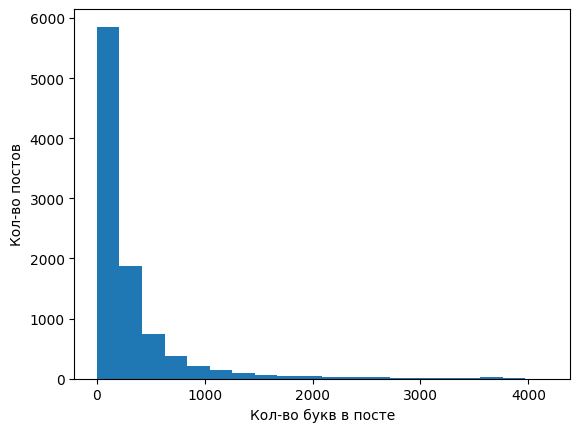

In [6]:
text_lenths = data['text_preprocessed'].str.len()

plt.hist(text_lenths, bins=20)
plt.xlabel('Кол-во букв в посте')
plt.ylabel('Кол-во постов')
plt.show()

In [7]:
data = data.loc[(data['text_preprocessed'].str.len() >= 50) & (data['text_preprocessed'].str.len() <= 1000)]
data = data.reset_index(drop=True)
data.shape

(7002, 2)

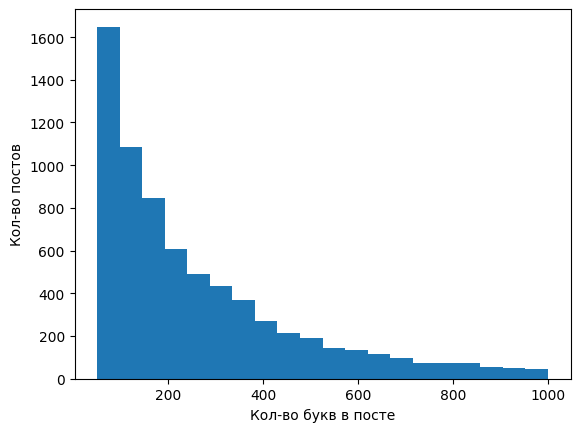

In [8]:
text_lenths = data['text_preprocessed'].str.len()

plt.hist(text_lenths, bins=20)
plt.xlabel('Кол-во букв в посте')
plt.ylabel('Кол-во постов')
plt.show()

In [9]:
data.head()

,text_preprocessed,label
0,продаем тем временем с 5-процентной выгодой бу...,sell
1,зато совершаем по итогам вчерашнего дня самую ...,buy
2,в 2022 году башнефть прирастила запасы нефти и...,neutral
3,вот сегодня отчитались и . .. из-за демпфера б...,sell
4,башнефть может выплатить неплохие дивиденды по...,neutral


In [10]:
(data.head()['text_preprocessed'][2])

'в 2022 году башнефть прирастила запасы нефти и газа в объеме 20,6 млн т нефтяного эквивалента.. .'

In [11]:
data['label'].value_counts()

neutral    2982
buy        2148
sell       1872
Name: label, dtype: int64

Проведена предобработка текстов, распределение классов почти равномерное.

### **Fine-tuning & Validation**

Возьмем rubert-base-cased, заморозим слои, наденем классификационную голову и её затюним :)

In [25]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm_gui
from torch.optim.lr_scheduler import ExponentialLR
import time

tqdm.pandas(bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')

In [14]:
class BERTWithMLP(nn.Module):
    def __init__(self, bert_model_name, num_labels=3, hidden_size=768, dropout_prob=0.1):
        super().__init__()
        # Загружаем BERT без головы
        self.bert = BertModel.from_pretrained(bert_model_name)
        
        # Замораживаем все слои BERT
        for param in self.bert.parameters():
            param.requires_grad = False
            
        # Наша MLP голова
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, num_labels)
        )
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(pooled_output)
        return logits

In [15]:
class FinancialDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_map = {'buy': 0, 'sell': 1, 'neutral': 2}
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.label_map[self.labels[idx]]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [34]:
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BERTWithMLP(model_name, num_labels=3)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# Разделение данных для обучения
train_df, val_df = train_test_split(data, test_size=0.1, random_state=42)

In [18]:
train_dataset = FinancialDataset(
    train_df['text_preprocessed'].values,
    train_df['label'].values,
    tokenizer
)

val_dataset = FinancialDataset(
    val_df['text_preprocessed'].values,
    val_df['label'].values,
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

epochs = 10
initial_lr = 1e-3
final_lr = 2e-5

optimizer = AdamW(model.parameters(), lr=initial_lr)
loss_fn = torch.nn.CrossEntropyLoss()

gamma = (final_lr / initial_lr) ** (1 / (epochs - 1))
scheduler = ExponentialLR(optimizer, gamma=gamma)

print(device)
print(f"Gamma: {gamma:.4f}")

cuda:0
Gamma: 0.6475


In [36]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

# Инициализация для логирования
train_loss_history = []  # Лосс на каждом батче трейна
val_loss_history = []    # Лосс на каждом батче валидации
epoch_train_loss = []    # Средний лосс по эпохам (тренировка)
epoch_val_loss = []      # Средний лосс по эпохам (валидация)


for epoch in range(epochs):
    model.train()
    total_loss = 0
    batch_train_loss = []
    
    train_iterator = tqdm(train_loader, 
                         desc=f'Epoch {epoch+1}/{epochs} [LR={optimizer.param_groups[0]["lr"]:.2e}]', 
                         bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}',
                         colour='green')
    
    for batch in train_iterator:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        batch_train_loss.append(loss.item())
        train_iterator.set_postfix({
            'batch_loss': f'{loss.item():.4f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.1e}'
        })

    scheduler.step() # двигаем шедулер
    train_loss_history.extend(batch_train_loss)
    epoch_train_loss.append(total_loss/len(train_loader))
    
    with tqdm.external_write_mode():
        tqdm.write(f"\nEpoch {epoch+1} Summary:")
        tqdm.write(f"Train Loss: {epoch_train_loss[-1]:.4f}")
    
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    batch_val_loss = []
    
    val_iterator = tqdm(val_loader, 
                       desc=f'Epoch {epoch+1}/{epochs} [VAL]', 
                       bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}',
                       colour='blue')
    
    with torch.no_grad():
        for batch in val_iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()
            batch_val_loss.append(loss.item())
            
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            val_iterator.set_postfix({'batch_acc': f'{(predicted == labels).float().mean().item():.2f}'})
    
    val_loss_history.extend(batch_val_loss)
    epoch_val_loss.append(val_loss/len(val_loader))
    
    with tqdm.external_write_mode():
        tqdm.write(f"Val Loss: {epoch_val_loss[-1]:.4f}")
        tqdm.write(f"Val Accuracy: {correct/total:.4f}\n")
    
    time.sleep(0.5)

Epoch 1/10 [LR=1.00e-03]: 100%|██████████████████████████████| 99/99 [00:20<00:00,  4.74it/s, batch_loss=1.1089, lr=1.0e-03]



Epoch 1 Summary:
Train Loss: 1.0120


Epoch 1/10 [VAL]: 100%|██████████████████████████████| 11/11 [00:02<00:00,  5.19it/s, batch_acc=0.52]


Val Loss: 0.9661
Val Accuracy: 0.5278



Epoch 2/10 [LR=6.47e-04]: 100%|██████████████████████████████| 99/99 [00:20<00:00,  4.75it/s, batch_loss=0.8980, lr=6.5e-04]



Epoch 2 Summary:
Train Loss: 0.9505


Epoch 2/10 [VAL]: 100%|██████████████████████████████| 11/11 [00:02<00:00,  5.20it/s, batch_acc=0.57]


Val Loss: 0.9341
Val Accuracy: 0.5549



Epoch 3/10 [LR=4.19e-04]: 100%|██████████████████████████████| 99/99 [00:20<00:00,  4.74it/s, batch_loss=0.9117, lr=4.2e-04]



Epoch 3 Summary:
Train Loss: 0.9242


Epoch 3/10 [VAL]: 100%|██████████████████████████████| 11/11 [00:02<00:00,  5.18it/s, batch_acc=0.57]


Val Loss: 0.9262
Val Accuracy: 0.5421



Epoch 4/10 [LR=2.71e-04]: 100%|██████████████████████████████| 99/99 [00:20<00:00,  4.73it/s, batch_loss=0.8438, lr=2.7e-04]



Epoch 4 Summary:
Train Loss: 0.9140


Epoch 4/10 [VAL]: 100%|██████████████████████████████| 11/11 [00:02<00:00,  5.18it/s, batch_acc=0.64]


Val Loss: 0.9195
Val Accuracy: 0.5535



Epoch 5/10 [LR=1.76e-04]: 100%|██████████████████████████████| 99/99 [00:20<00:00,  4.72it/s, batch_loss=0.7689, lr=1.8e-04]



Epoch 5 Summary:
Train Loss: 0.9019


Epoch 5/10 [VAL]: 100%|██████████████████████████████| 11/11 [00:02<00:00,  5.18it/s, batch_acc=0.66]


Val Loss: 0.9083
Val Accuracy: 0.5506



Epoch 6/10 [LR=1.14e-04]: 100%|██████████████████████████████| 99/99 [00:20<00:00,  4.73it/s, batch_loss=0.9194, lr=1.1e-04]



Epoch 6 Summary:
Train Loss: 0.8973


Epoch 6/10 [VAL]: 100%|██████████████████████████████| 11/11 [00:02<00:00,  5.19it/s, batch_acc=0.61]


Val Loss: 0.9076
Val Accuracy: 0.5492



Epoch 7/10 [LR=7.37e-05]: 100%|██████████████████████████████| 99/99 [00:20<00:00,  4.72it/s, batch_loss=0.6930, lr=7.4e-05]



Epoch 7 Summary:
Train Loss: 0.8979


Epoch 7/10 [VAL]: 100%|██████████████████████████████| 11/11 [00:02<00:00,  5.18it/s, batch_acc=0.62]


Val Loss: 0.9041
Val Accuracy: 0.5506



Epoch 8/10 [LR=4.77e-05]: 100%|██████████████████████████████| 99/99 [00:20<00:00,  4.73it/s, batch_loss=0.9392, lr=4.8e-05]



Epoch 8 Summary:
Train Loss: 0.8936


Epoch 8/10 [VAL]: 100%|██████████████████████████████| 11/11 [00:02<00:00,  5.20it/s, batch_acc=0.62]


Val Loss: 0.9011
Val Accuracy: 0.5563



Epoch 9/10 [LR=3.09e-05]: 100%|██████████████████████████████| 99/99 [00:20<00:00,  4.72it/s, batch_loss=0.8568, lr=3.1e-05]



Epoch 9 Summary:
Train Loss: 0.8852


Epoch 9/10 [VAL]: 100%|██████████████████████████████| 11/11 [00:02<00:00,  5.18it/s, batch_acc=0.62]


Val Loss: 0.9018
Val Accuracy: 0.5563



Epoch 10/10 [LR=2.00e-05]: 100%|██████████████████████████████| 99/99 [00:20<00:00,  4.73it/s, batch_loss=0.9663, lr=2.0e-05]



Epoch 10 Summary:
Train Loss: 0.8850


Epoch 10/10 [VAL]: 100%|██████████████████████████████| 11/11 [00:02<00:00,  5.18it/s, batch_acc=0.64]


Val Loss: 0.9010
Val Accuracy: 0.5535



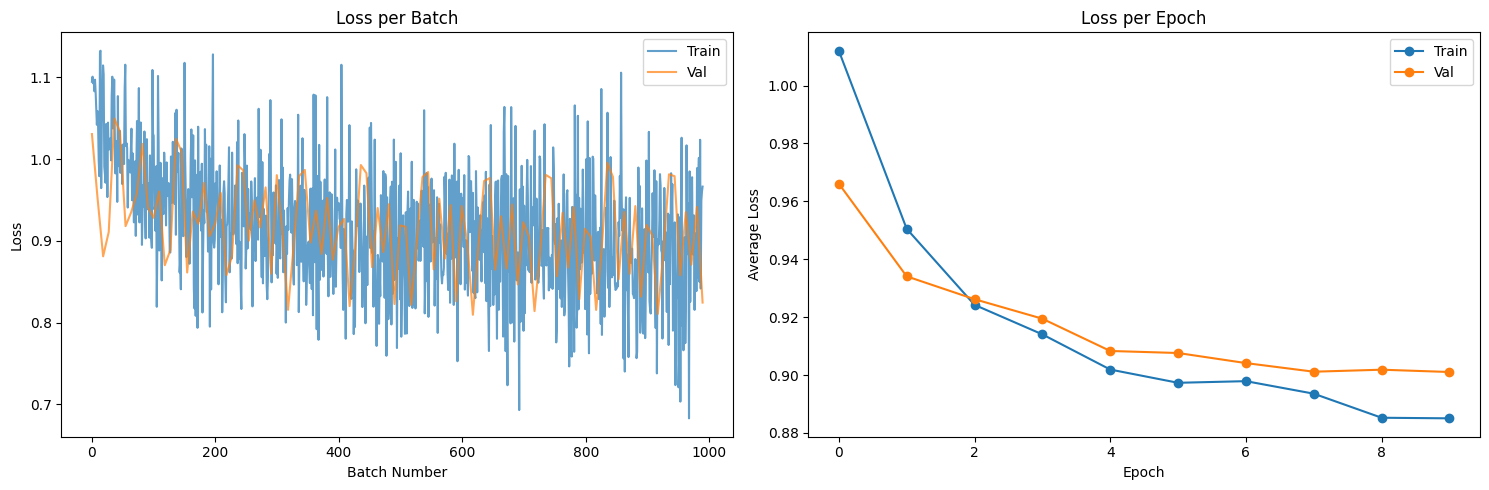

In [37]:
# Визуализация после обучения
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train', alpha=0.7)
plt.plot(np.linspace(0, len(train_loss_history)-1, len(val_loss_history)), 
         val_loss_history, label='Val', alpha=0.7)
plt.title('Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_train_loss, label='Train', marker='o')
plt.plot(epoch_val_loss, label='Val', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Вывод финальных метрик
# print(f"\nFinal Metrics:")
# print(f"Train Loss: {epoch_train_loss[-1]:.4f}")
# print(f"Val Loss: {epoch_val_loss[-1]:.4f}")
# print(f"Val Accuracy: {correct/total:.4f}")

Видно, что дальше нет смысла обучать, мы вышли на плато и началось переобучение. Видимо задача довольно сложная для ruBERT, или же данные слишком шумные. Посмотрим на скор на тест сете.

In [38]:
torch.save({
    'classifier_state_dict': model.classifier.state_dict(), # только голову сохраняем, она весит 2 мб
    'classifier_config': {
        'hidden_size': 768,
        'num_labels': 3,
        'dropout_prob': 0.1
    }
}, 'rubert_mlp_head.pth')

**Вектор для дальнейших экспериментов:**
- Взять rubert-base-cased, разморозить верхние слои + классификационную голову. Попробуем обучить часть модели и голову и посмотрим на результат.
- Взять другую модель, например, большой берт или Roberta. Сравнить результаты.

### **Tests**

In [ ]:
from sklearn.metrics import classification_report

def load_mlp_head(model_path):
    checkpoint = torch.load(model_path)
    model = BERTWithMLP(
        bert_model_name='DeepPavlov/rubert-base-cased',
        num_labels=checkpoint['classifier_config']['num_labels'],
        hidden_size=checkpoint['classifier_config']['hidden_size'],
        dropout_prob=checkpoint['classifier_config']['dropout_prob']
    )
    model.classifier.load_state_dict(checkpoint['classifier_state_dict'])
    return model


def evaluate_on_test(test_df, model, device):
    model.to(device)
    model.eval()
    
    test_dataset = FinancialDataset(
        test_df['text_preprocessed'].values,
        test_df['label'].values,
        tokenizer
    )
    test_loader = DataLoader(test_dataset, batch_size=64)
    
    true_labels = []
    predictions = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].cpu().numpy()
            
            logits = model(input_ids, attention_mask)
            _, preds = torch.max(logits, 1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels)
    
    print(classification_report(true_labels, predictions, target_names=['buy', 'sell', 'neutral']))

**Проверка качества на голдене**

In [42]:
tuned_model = load_mlp_head('rubert_mlp_head.pth')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
evaluate_on_test(
    test_df=test_set,
    model=tuned_model,
    device=device,
)

              precision    recall  f1-score   support

         buy       0.47      0.74      0.58       142
        sell       0.57      0.34      0.43       116
     neutral       0.72      0.62      0.67       242

    accuracy                           0.59       500
   macro avg       0.59      0.57      0.56       500
weighted avg       0.62      0.59      0.59       500



**Результаты работы**

- Была обучена голова для модели RuBERT-base-cased для задачи определения финансового сентимента.
- Качество на тест-сете ручной разметки составило accuracy=0.59, что не есть хорошо. Скорее всего есть более сложные смысловые зависимости в постах, которые модель BERT не распознает.
- Лучше всего распознается класс neutral с f1=0.67
- План для дальнейшего исследования: тюнинг больших моделей, разметка большего датасета